<a href="https://colab.research.google.com/github/RevathyRamalingam/machineLearning/blob/main/08-DeepLearning/Module8_DeepLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
from PIL import Image


In [62]:
import os

os.system("wget https://github.com/SVizor42/ML_Zoomcamp/releases/download/straight-curly-data/data.zip")


0

In [63]:
from tensorflow.keras.preprocessing.image import load_img

In [64]:
import torch

# Original tensor
x = torch.tensor([[3, 1],
     [1,1]])
print(x.shape)

# Unsqueeze at position 0
y = torch.unsqueeze(x, 1)
print(y.shape)


torch.Size([2, 2])
torch.Size([2, 1, 2])


In [65]:
import zipfile

with zipfile.ZipFile('data.zip', 'r') as zip_ref:
    zip_ref.extractall()  # Specify the folder where you want to extract the files
#let's count the images in train directory

# Directory path
directory = "./data/train"

# Initialize counter for image files
image_count = 0

image_extensions = {".jpg", ".jpeg", ".png", ".gif", ".bmp", ".tiff"}
# Iterate through all files in the directory
for root,dirs,files in os.walk(directory):
    # Get the full file path
    for filename in files:
      file_path = os.path.join(root, filename)
      _, ext = os.path.splitext(filename)


      # check the imagefile extension
      if ext.lower() in image_extensions:
            image_count += 1

# Output the result
print(f"Number of images in directory: {image_count}")


import numpy as np
import torch

SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)

if torch.cuda.is_available():
    torch.cuda.manual_seed(SEED)
    torch.cuda.manual_seed_all(SEED)

torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Number of images in directory: 801


In [66]:
import os
from torch.utils.data import Dataset

class HairDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data_dir = data_dir
        self.transform = transform
        self.image_paths = []
        self.labels = []
        self.classes = sorted(os.listdir(data_dir))
        #print("classes are ",self.classes)
        self.class_to_idx = {cls: i for i, cls in enumerate(self.classes)}

        for label_name in self.classes:
            label_dir = os.path.join(data_dir, label_name)
            for img_name in os.listdir(label_dir):
                self.image_paths.append(os.path.join(label_dir, img_name))
                self.labels.append(self.class_to_idx[label_name])

    def __len__(self):
        #print("length of images in path ",self.image_paths," is",len(self.image_paths))
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        image = Image.open(img_path).convert('RGB')
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

In [67]:
from torchvision import transforms
input_size = 200


# Simple transforms - just resize and normalize
train_transforms = transforms.Compose([
    transforms.RandomRotation(50),
    transforms.RandomResizedCrop(200, scale=(0.9, 1.0), ratio=(0.9, 1.1)),
    transforms.RandomHorizontalFlip(),
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ) #,

])

test_transforms = transforms.Compose([
    transforms.Resize((200, 200)),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ) # ImageNet normalization
])

In [68]:
from torch.utils.data import DataLoader

train_dataset = HairDataset(
    data_dir='./data/train',
    transform=train_transforms
)

test_dataset = HairDataset(
    data_dir='./data/test',
    transform=test_transforms
)

train_loader = DataLoader(train_dataset, batch_size=20, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=20, shuffle=False)
print(train_dataset.classes)



['curly', 'straight']


In [69]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import torch.nn.functional as F

# Define the CNN custom model class
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3)
        self.pool = nn.MaxPool2d(kernel_size=2)

        self.fc1 = nn.Linear(32 * 99 * 99, 64)
        self.fc2 = nn.Linear(64, 1)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        #print("x shape before conv1",x.shape)
        x = self.relu(self.conv1(x))
        #print("x shape after conv1",x.shape)
        x = self.pool(x)
        #print("x shape after pool",x.shape)
        x = x.view(x.size(0), -1)
        #print("x shape after view",x.shape)
        x = self.relu(self.fc1(x))
        #print("x shape after fc1",x.shape)
        x = self.fc2(x)
        #print("x shape after fc2",x.shape)
        return x

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Create the model and move it to the correct device
model = CNNModel()
model.to(device)

# Define the optimizer and loss function
optimizer = optim.SGD(model.parameters(), lr=0.002, momentum=0.8)
criterion = nn.BCEWithLogitsLoss()

# Option 1: Using torchsummary (install with: pip install torchsummary)
from torchsummary import summary
summary(model, input_size=(3, 200, 200))

# Option 2: Manual counting
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 198, 198]             896
              ReLU-2         [-1, 32, 198, 198]               0
         MaxPool2d-3           [-1, 32, 99, 99]               0
            Linear-4                   [-1, 64]      20,072,512
              ReLU-5                   [-1, 64]               0
            Linear-6                    [-1, 1]              65
Total params: 20,073,473
Trainable params: 20,073,473
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.46
Forward/backward pass size (MB): 21.54
Params size (MB): 76.57
Estimated Total Size (MB): 98.57
----------------------------------------------------------------
Total parameters: 20073473


In [70]:
best_acc=0.0
num_epochs = 10
history = {'acc': [], 'loss': [], 'val_acc': [], 'val_loss': []}

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    correct_train = 0
    total_train = 0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        labels = labels.float().unsqueeze(1) # Ensure labels are float and have shape (batch_size, 1)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        #print("image size",images.size(0))
        running_loss += loss.item() * images.size(0)
        # For binary classification with BCEWithLogitsLoss, apply sigmoid to outputs before thresholding for accuracy
        #print("output is",outputs)
        predicted = (torch.sigmoid(outputs)> 0.5).float()
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_acc = correct_train / total_train
    history['loss'].append(epoch_loss)
    history['acc'].append(epoch_acc)

    model.eval()
    val_running_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            labels = labels.float().unsqueeze(1)

            outputs = model(images)
            loss = criterion(outputs, labels)

            val_running_loss += loss.item() * images.size(0)
            predicted = (torch.sigmoid(outputs)> 0.5).float()
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_epoch_loss = val_running_loss / len(test_loader.dataset)
    val_epoch_acc = correct_val / total_val
    #print("loss ",val_epoch_loss)
    #print("acc ",val_epoch_acc)
    history['val_loss'].append(val_epoch_loss)
    history['val_acc'].append(val_epoch_acc)

    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Loss: {epoch_loss:.4f}, Acc: {epoch_acc:.4f}, "
          f"Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}")
    if val_epoch_acc>best_acc:
        best_acc=val_epoch_acc
    checkpoint_path = f'hairclassifier_v1_{epoch+1:02d}_{val_epoch_acc:.3f}.pth'
    torch.save(model.state_dict(), checkpoint_path)
    print(f'Checkpoint saved: {checkpoint_path}')


Epoch 1/10, Loss: 0.6357, Acc: 0.6305, Val Loss: 0.6566, Val Acc: 0.5920
Checkpoint saved: hairclassifier_v1_01_0.592.pth
Epoch 2/10, Loss: 0.6212, Acc: 0.6592, Val Loss: 0.7857, Val Acc: 0.5771
Checkpoint saved: hairclassifier_v1_02_0.577.pth
Epoch 3/10, Loss: 0.6679, Acc: 0.6504, Val Loss: 0.6443, Val Acc: 0.6517
Checkpoint saved: hairclassifier_v1_03_0.652.pth
Epoch 4/10, Loss: 0.5886, Acc: 0.6816, Val Loss: 0.5987, Val Acc: 0.6567
Checkpoint saved: hairclassifier_v1_04_0.657.pth
Epoch 5/10, Loss: 0.5963, Acc: 0.6754, Val Loss: 0.7062, Val Acc: 0.6318
Checkpoint saved: hairclassifier_v1_05_0.632.pth
Epoch 6/10, Loss: 0.5785, Acc: 0.6879, Val Loss: 0.8269, Val Acc: 0.5622
Checkpoint saved: hairclassifier_v1_06_0.562.pth
Epoch 7/10, Loss: 0.6016, Acc: 0.6767, Val Loss: 0.6074, Val Acc: 0.6517
Checkpoint saved: hairclassifier_v1_07_0.652.pth
Epoch 8/10, Loss: 0.5853, Acc: 0.6891, Val Loss: 0.6076, Val Acc: 0.6468
Checkpoint saved: hairclassifier_v1_08_0.647.pth
Epoch 9/10, Loss: 0.5795

In [71]:
np.median(history['acc'])

np.float64(0.6791510611735331)

In [72]:
np.std(history['loss'])

np.float64(0.029162817856782423)

In [73]:
print("average of last 5 epochs",np.mean(history['val_acc'][5:10]))
np.mean(history['val_loss'])

average of last 5 epochs 0.6109452736318408


np.float64(0.6819571323285055)

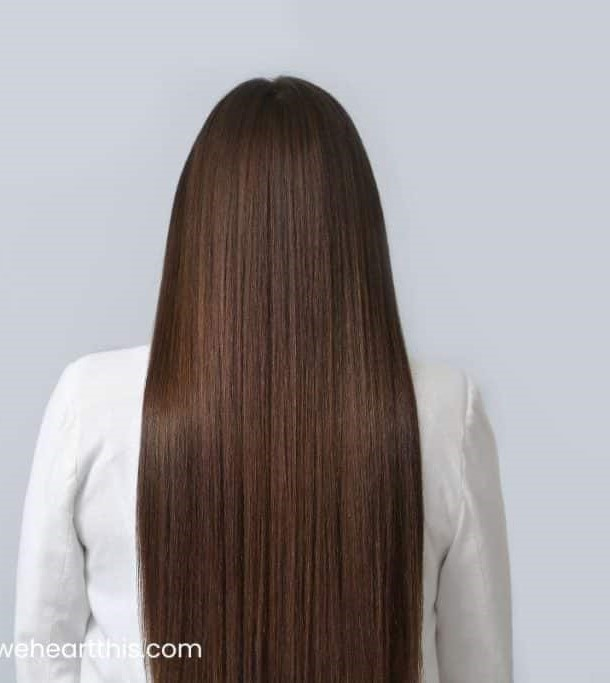

In [74]:
img = Image.open('./data/train/straight/1a-hair-type-1-1024x683.jpg')
img

In [83]:
path = 'hairclassifier_v1_02_0.806.pth'
model = CNNModel().to(device)
model.load_state_dict(torch.load(path))
model.eval()  # You don't need model.to(device) twice

x = test_transforms(img)
batch_t = torch.unsqueeze(x, 0).to(device)

with torch.no_grad():
    output = model(batch_t)
    probability = torch.sigmoid(output.squeeze())
    predicted_class_idx = int((probability > 0.5).item())

# Print results
print(f"Predicted class: {train_dataset.classes[predicted_class_idx]}")
print(f"Confidence: {probability.item():.4f}")

Predicted class: straight
Confidence: 0.9941
